In [1]:
import pandas as pd
import numpy as np

In [2]:
current_facilities = pd.read_csv("../data/ermera_full/current_facs.csv")
current_facilities["is_built"] = 1
current_facilities = current_facilities.drop(columns=["Hosp_Name"])
current_facilities.columns = ["Pop_Lat", "Pop_Lon", "Population", "Grid_Lat", "Grid_Lon", "Distance_KM", "is_built"]

In [3]:
data_potential = pd.read_csv("../data/ermera_full/grid.csv")
data_potential["is_built"] = 0

In [4]:
data = pd.concat([data_potential, current_facilities], ignore_index=True)

In [5]:
#populations = data_potential[["Pop_Lat", "Pop_Lon", "Population"]].drop_duplicates().reset_index().drop(columns=["index"])
#populations_covered = current_facilities[["Pop_Lat", "Pop_Lon", "Population"]].drop_duplicates().reset_index().drop(columns=["index"])
populations = data[["Pop_Lat", "Pop_Lon", "Population"]].drop_duplicates().reset_index().drop(columns=["index"])

In [6]:
#facilities = data_potential[["Grid_Lat", "Grid_Lon", "is_built"]].drop_duplicates().reset_index().drop(columns=["index"])
#facilities_built = current_facilities[["Grid_Lat", "Grid_Lon", "is_built"]].drop_duplicates().reset_index().drop(columns=["index"])
facilities = data[["Grid_Lat", "Grid_Lon", "is_built"]].drop_duplicates().reset_index().drop(columns=["index"])

In [7]:
distances = pd.DataFrame(
    columns=facilities.index.astype(int),
    index=populations.index.astype(int),
    data=np.nan
)

In [8]:
for i, population in populations.iterrows():
    for j, facility in facilities.iterrows():
        matching_row = data[
            (data["Pop_Lat"] == population["Pop_Lat"]) &
            (data["Pop_Lon"] == population["Pop_Lon"]) &
            (data["Grid_Lat"] == facility["Grid_Lat"]) &
            (data["Grid_Lon"] == facility["Grid_Lon"])
        ]

        if not matching_row.empty:
            distances.at[i,j] = matching_row.iloc[0]["Distance_KM"]

In [10]:
distances.replace(np.nan, 1000, inplace=True)

In [11]:
populations.to_csv("../data/ermera_full/processed/populations.csv")
facilities.to_csv("../data/ermera_full/processed/facilities.csv")
distances.to_csv("../data/ermera_full/processed/distances.csv")

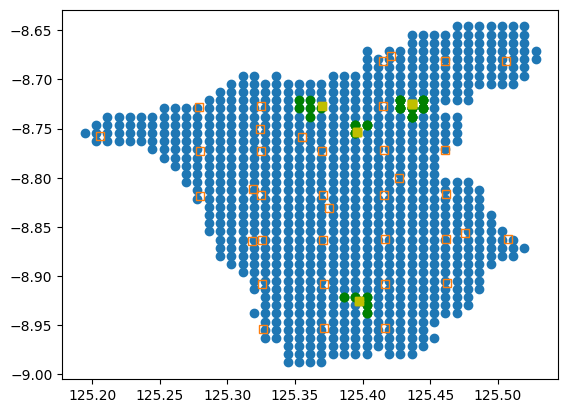

In [13]:
import pandas as pd
import numpy as np
from dynamic_models.single_step import single_step_area
from dynamic_models.visuializer import show_facility_location

#data constants
distances = pd.read_csv("../data/ermera_full/processed/distances.csv").drop(columns=["Unnamed: 0"])
homes = populations
locations = facilities
periods_df = pd.DataFrame([1,2,3,4])
periods = periods_df[0]
per_period = 1
max_distance = 2
vpop = homes["Population"]


Z, X, building = single_step_area(distances, homes, locations, periods, per_period, max_distance, vpop)

xC = homes['Pop_Lon']
yC = homes['Pop_Lat']
xF = locations['Grid_Lon']
yF = locations['Grid_Lat']

show_facility_location(xC, yC, xF, yF, X=X, Z=Z, homes=homes, locations=locations, periods=periods)

In [15]:
distances

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,33.0,67.0,38.0,32.0,33.0,34.0,42.0,52.0,59.0,25.0,...,29.0,30.0,19.0,24.0,24.0,29.0,15.0,34.0,41.0,6.0
1,35.0,68.0,39.0,33.0,34.0,35.0,43.0,52.0,58.0,26.0,...,31.0,30.0,20.0,26.0,25.0,30.0,16.0,35.0,42.0,7.0
2,35.0,69.0,39.0,34.0,34.0,36.0,43.0,52.0,58.0,27.0,...,31.0,30.0,21.0,26.0,25.0,31.0,17.0,35.0,43.0,8.0
3,36.0,70.0,40.0,34.0,35.0,36.0,44.0,51.0,58.0,27.0,...,32.0,29.0,21.0,27.0,26.0,32.0,17.0,36.0,44.0,10.0
4,36.0,71.0,41.0,35.0,36.0,37.0,44.0,52.0,58.0,28.0,...,32.0,30.0,22.0,27.0,26.0,32.0,18.0,36.0,44.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
904,62.0,115.0,56.0,60.0,61.0,52.0,47.0,49.0,55.0,53.0,...,44.0,31.0,47.0,39.0,52.0,57.0,46.0,52.0,47.0,55.0
905,65.0,74.0,43.0,63.0,64.0,44.0,35.0,24.0,6.0,56.0,...,43.0,32.0,50.0,42.0,55.0,60.0,49.0,43.0,35.0,58.0
906,57.0,74.0,39.0,55.0,56.0,36.0,26.0,16.0,7.0,48.0,...,34.0,24.0,42.0,34.0,47.0,52.0,41.0,35.0,27.0,50.0
907,56.0,74.0,38.0,55.0,56.0,35.0,26.0,16.0,6.0,48.0,...,34.0,24.0,42.0,34.0,46.0,52.0,40.0,34.0,26.0,49.0


In [16]:
facilities

,Grid_Lat,Grid_Lon,is_built
0,-8.727863,125.279158,0
1,-8.773053,125.279433,0
2,-8.818243,125.279710,0
3,-8.727587,125.324578,0
4,-8.772776,125.324858,0
5,-8.817965,125.325140,0
6,-8.863153,125.325424,0
7,-8.908341,125.325709,0
8,-8.953529,125.325995,0
9,-8.727306,125.369996,0


In [17]:
populations

,Pop_Lat,Pop_Lon,Population
0,-8.646250,125.469583,32
1,-8.646250,125.477916,32
2,-8.646250,125.486250,32
3,-8.646250,125.494583,33
4,-8.646250,125.502916,37
...,...,...,...
904,-8.979583,125.436250,37
905,-8.987916,125.344583,146
906,-8.987916,125.352916,180
907,-8.987916,125.361250,172
